# Lab 07: White Box AI

You want to make the perfect toast. You have hacked a toaster with sensors and toasted over 1000 toasts. How can we predict the optimal toasting time for a given toast?

## Preliminary

Let's first generate and explore the data.

We have collected data from 1,000 toasting attempts.

Our Data Features:

-    ```ToastingTime```: How long the toast was in for (seconds).
-    ```BreadThickness```: The thickness of the slice (mm).
-    ```IsFrozen```: A button on our toaster (0 for No, 1 for Yes).
-    ```AmbientTemp```: The room temperature (°C).

Our Target Variable:

- ```ToastState```: The final result (Under-done, Perfect, or Burnt).


Run the code below to generate a pseudo-random dataset. Do not change the seed!

In [80]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_toaster_data_interactive(n_samples=1000):
    # Feature Generation
    toasting_time = np.random.randint(60, 500, n_samples)
    bread_thickness = np.random.uniform(5, 30, n_samples)
    is_frozen = np.random.randint(0, 2, n_samples)
    ambient_temp = np.random.normal(20, 6, n_samples)

    # Non-linear ideal_time
    base_ideal_time = (30 + 1.5 * bread_thickness + 0.1 * bread_thickness**2 + 0.005 * bread_thickness**3)
    frozen_penalty = is_frozen * (base_ideal_time * (np.exp(0.04 * bread_thickness) - 1))
    unadjusted_ideal_time = base_ideal_time + frozen_penalty
    temp_efficiency_factor = np.exp(0.025 * (ambient_temp - 20))
    ideal_time = unadjusted_ideal_time / temp_efficiency_factor

    # Gaussian perfect_score
    perfect_window_width = 25 + bread_thickness # Thicker bread is more forgiving
    time_diff_sq = (toasting_time - ideal_time)**2
    perfect_score = np.exp(-time_diff_sq / (2 * perfect_window_width**2))

    # Sigmoid burnt score
    burn_onset_offset = 45  # Burning starts to happen ~45s after the ideal time
    burn_rate_k = 0.1       # Controls how quickly it goes from not-burnt to burnt
    time_past_ideal = toasting_time - ideal_time - burn_onset_offset
    burnt_score = 1 / (1 + np.exp(-burn_rate_k * time_past_ideal))

    # Add small noise to scores c.
    perfect_score += np.random.normal(0, 0.3, n_samples)
    burnt_score += np.random.normal(0, 0.3, n_samples)

    # Default to 'Under-done'
    toast_state = np.zeros(n_samples, dtype=int)

    # Classify as 'Perfect' if perfect_score is highest AND above a minimum threshold.
    is_perfect = (perfect_score > burnt_score) & (perfect_score > 0.6)
    toast_state[is_perfect] = 1

    # Classify as 'Burnt' if burnt_score is highest AND above a minimum threshold.
    is_burnt = (burnt_score > perfect_score) & (burnt_score > 0.5)
    toast_state[is_burnt] = 2

    # All other data points remain as 'Under-done'.
    # This creates non-linear boundaries between all three classes.

    df = pd.DataFrame({
        'ToastingTime': toasting_time,
        'BreadThickness': bread_thickness,
        'IsFrozen': is_frozen,
        'AmbientTemp': ambient_temp,
        'ToastState': toast_state
    })
    return df


df = generate_toaster_data_interactive()

# You can now inspect the new dataframe
print(df.head())

   ToastingTime  BreadThickness  IsFrozen  AmbientTemp  ToastState
0           162       27.419710         1    25.515374           0
1           495       16.849041         1    15.991135           2
2           408       21.688943         1    31.239787           2
3           330        9.307997         1    26.480288           2
4           166        9.807225         0    17.316069           2


We provide the following utility functions to visualise the distribution of a feature relative to another feature as follows:

```displayfeatures(df)``` Displays a matrix of the features plotted against each other

1. Each plot where x != y plots the the values of each feature against each other.
2. Each plot where x == y represents the distribution of the "toastiness" of the bread based on the considered feature.

```displayfeatures3D(df)``` Displays the 3 main features agains each other in 3D


In [81]:
from matplotlib import pyplot as plt

def displayfeatures(df):
    features = ['ToastingTime', 'BreadThickness', 'AmbientTemp']
    target_col = 'ToastState'
    class_labels = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
    colors = ['blue', 'green', 'red']

    fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))
    fig.suptitle('Visualizing Toaster Data Relationships', fontsize=16)

    for i, feature_y in enumerate(features):
        for j, feature_x in enumerate(features):
            ax = axes[i, j]

            # Plot histograms on the diagonal
            if i == j:
                ax.hist([df[df[target_col]==k][feature_x] for k in class_labels.keys()],
                        bins=15, histtype='barstacked', color=colors, label=list(class_labels.values()))
            # Plot scatter plots on the off-diagonal
            else:
                for k in class_labels.keys():
                    ax.scatter(df[df[target_col]==k][feature_x],
                            df[df[target_col]==k][feature_y],
                            s=10,
                            alpha=0.5,
                            color=colors[k],
                            label=class_labels[k])

            # Set axis labels
            if i==len(features)-1:
                ax.set_xlabel(feature_x)
            if j==0:
                ax.set_ylabel(feature_y)

    # Create a single legend for the entire figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

In [82]:
import plotly.express as px
import pandas as pd


def displayfeatures3D(df):
  fig = px.scatter_3d(df,
                      x='ToastingTime',
                      y='BreadThickness',
                      z='AmbientTemp',
                      color='ToastState',  # This column determines the color of the points
                      symbol='ToastState', # Use different symbols for each class
                      title="3D View of Toaster Data",
                      labels={
                          'ToastingTime': 'Toasting Time (s)',
                          'BreadThickness': 'Bread Thickness (mm)',
                          'AmbientTemp': 'Ambient Temperature (C)',
                          'ToastState': 'Final Toast State'
                      },
                      color_discrete_map={ # Explicitly set colors for clarity
                          'Under-done': 'blue',
                          'Perfect': 'green',
                          'Burnt': 'red'
                      },
                      height=700 # Make the plot a bit taller
                    )

  # Our ToastState variable is numerical. Plotly thus considers it as a scale rather than discrete values.
  # To avoid modifying our dataframe, we have to update the traces.
  label_map = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
  fig.for_each_trace(
    lambda trace: trace.update(name=label_map[int(float(trace.name))])
  )

  color_map = {'Under-done': 'blue','Perfect': 'green', 'Burnt': 'red'}
  fig.for_each_trace(
      lambda trace: trace.update(
          marker_color = color_map[trace.name]
      )
  )


  fig.show()

In [83]:
displayfeatures3D(df)

## Step 1: Explore the data

Check what the data looks like using the two functions defined above, as well as the pandas and matplotlib functions seen during class:

- ```df.head()```
- ```df.describe()```
- boxplots, histograms, scatter plots, etc.

The plotting functions ```displayfeatures(df)``` and ```displayfeatures3D(df)``` do not consider whether the bread is frozen or not. You may want to copy these functions to display the data with respect to the bread frozen feature.



First 5 rows of data:
   ToastingTime  BreadThickness  IsFrozen  AmbientTemp  ToastState
0           162       27.419710         1    25.515374           0
1           495       16.849041         1    15.991135           2
2           408       21.688943         1    31.239787           2
3           330        9.307997         1    26.480288           2
4           166        9.807225         0    17.316069           2


Data statistics:
       ToastingTime  BreadThickness     IsFrozen  AmbientTemp   ToastState
count   1000.000000     1000.000000  1000.000000  1000.000000  1000.000000
mean     280.208000       17.391427     0.532000    20.136454     1.227000
std      123.130182        7.252960     0.499225     5.847138     0.901268
min       60.000000        5.115801     0.000000     1.882927     0.000000
25%      179.000000       10.836142     0.000000    16.244376     0.000000
50%      281.000000       17.442131     1.000000    20.041589     2.000000
75%      388.250000       23.453

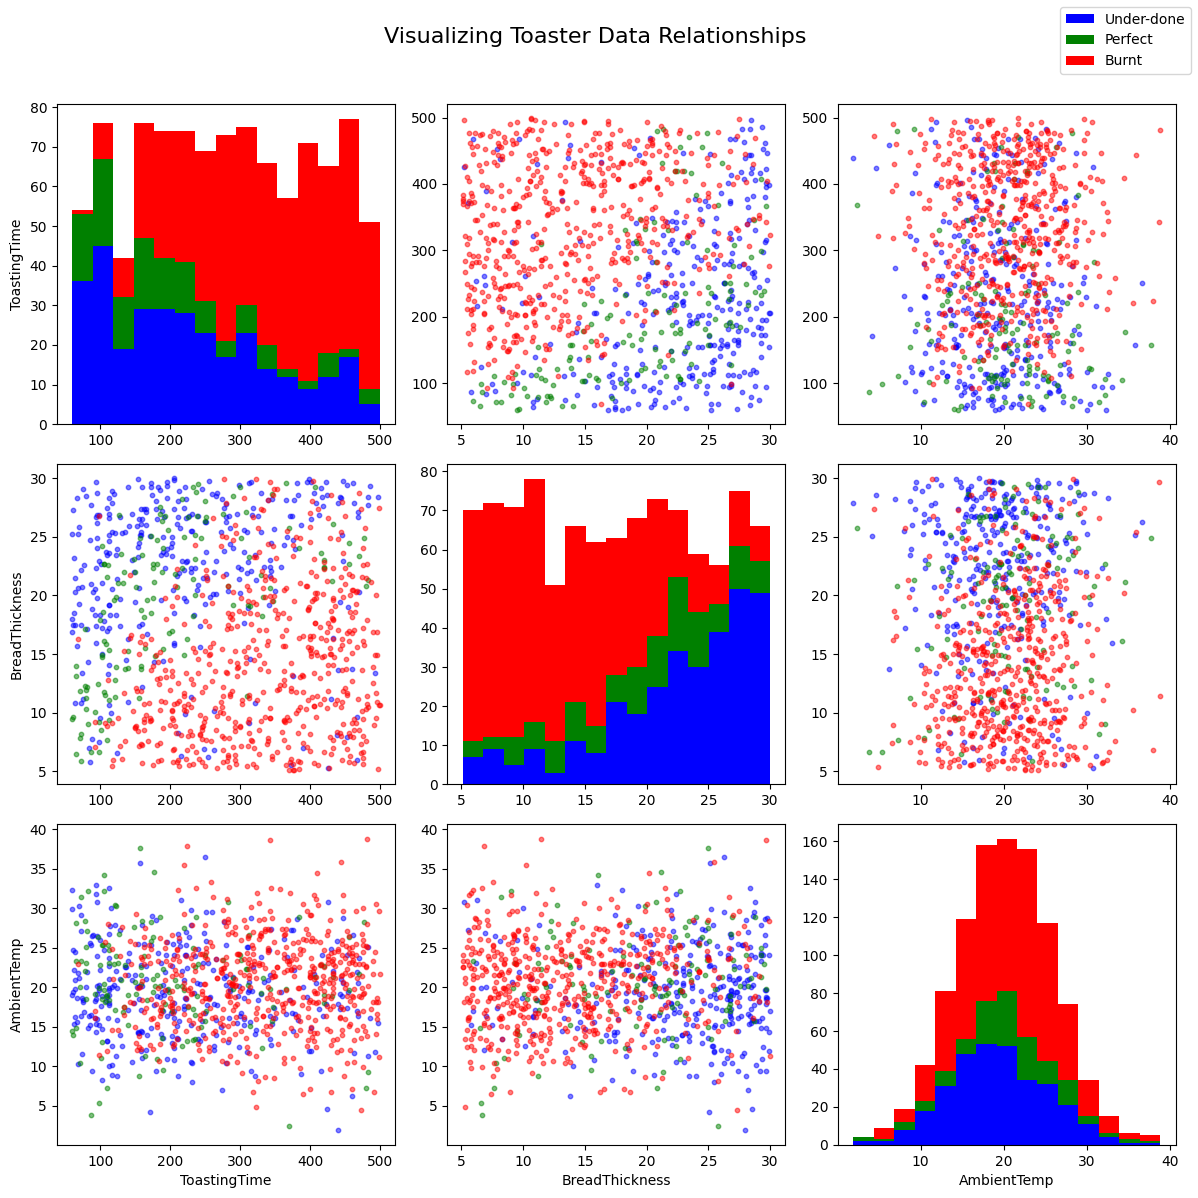

Displaying 3D feature visualization:


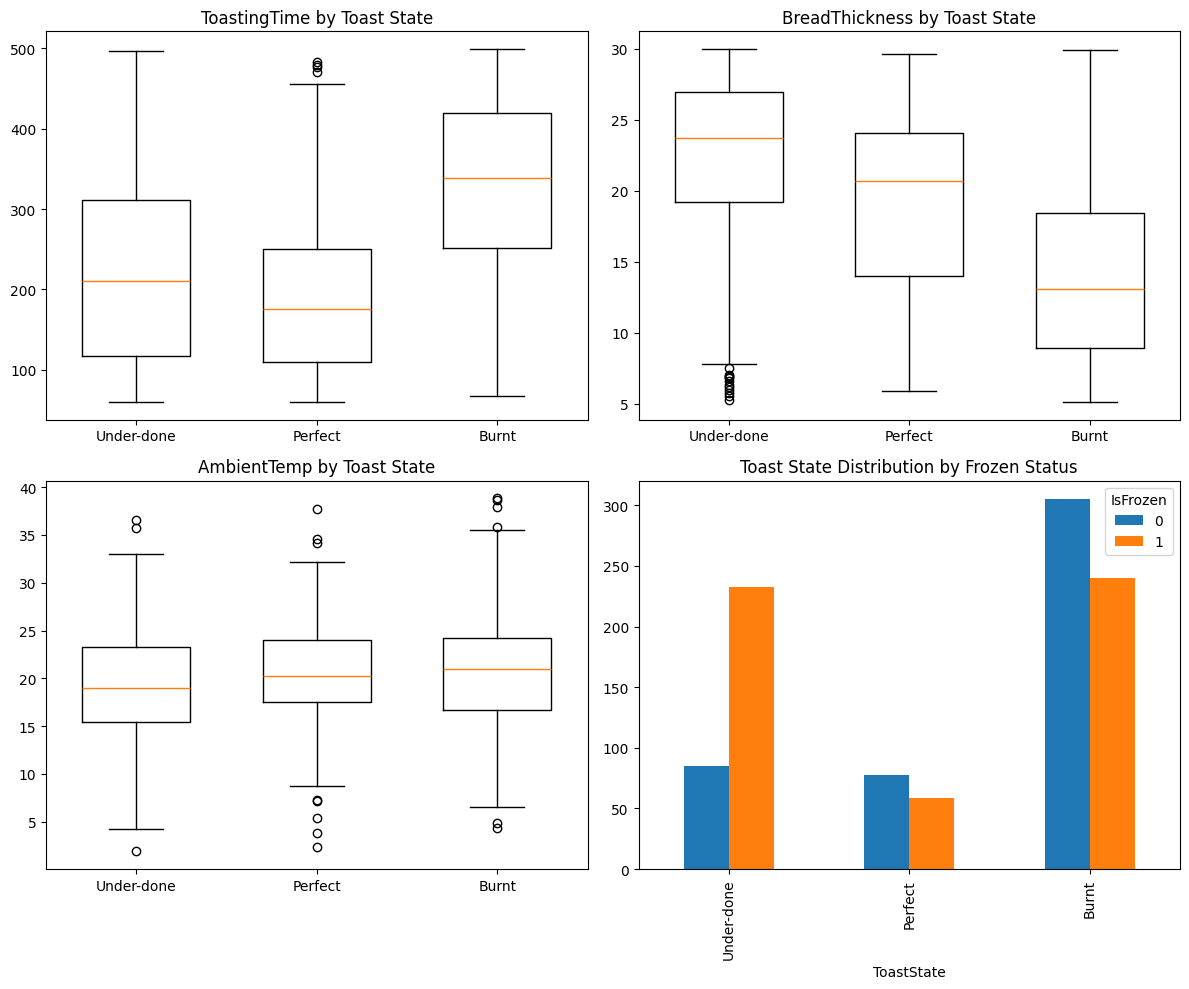

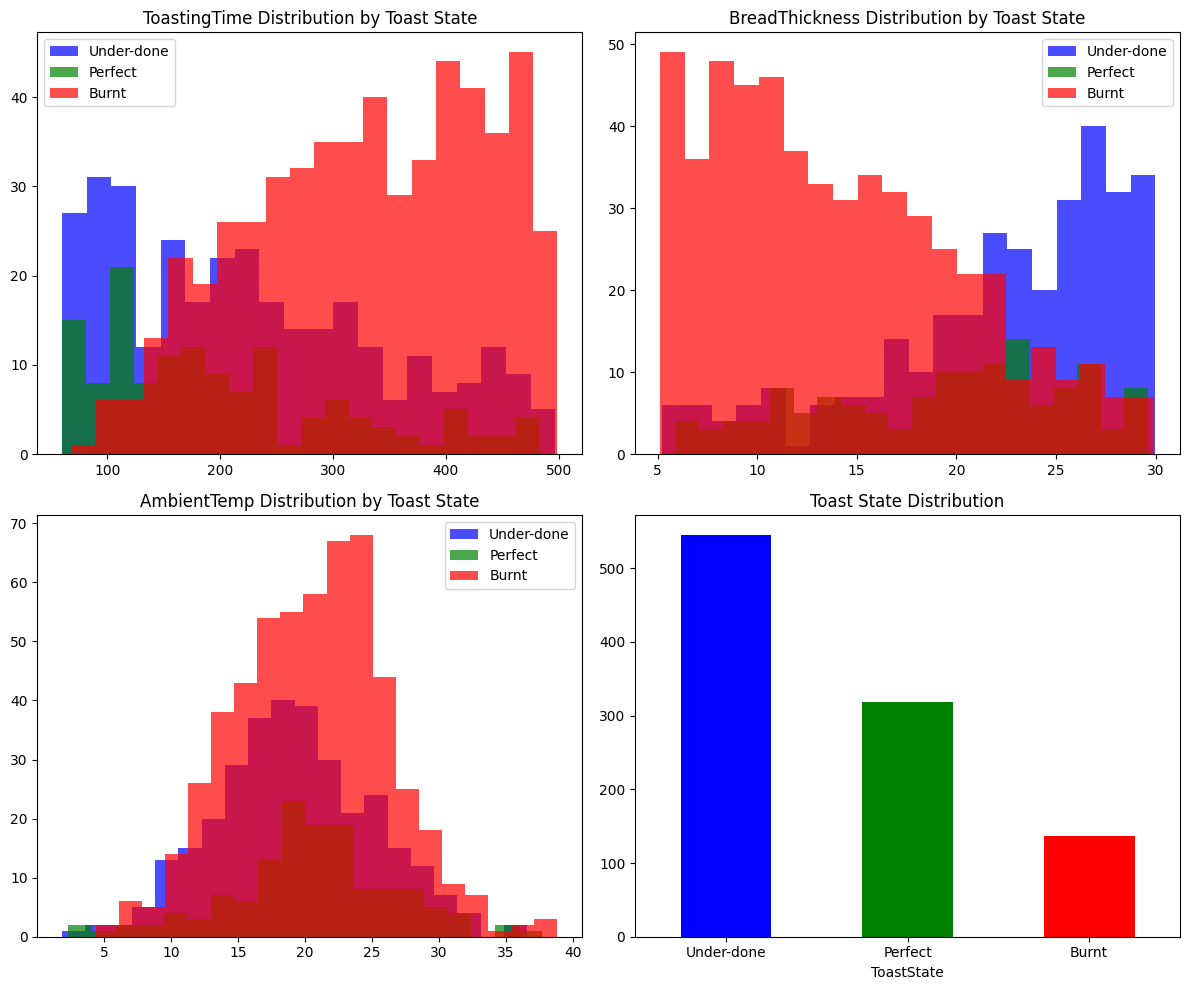

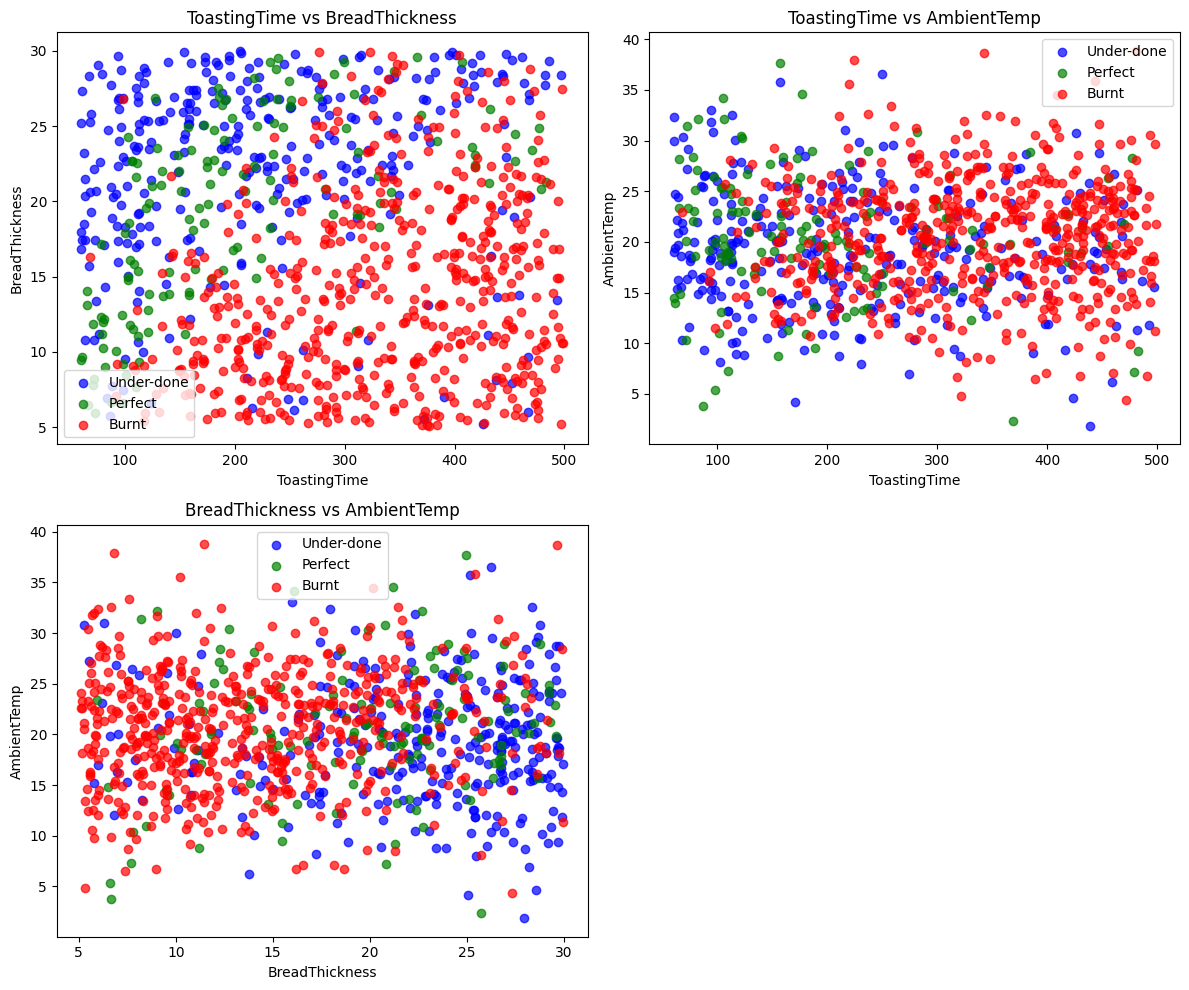

In [84]:
# 1. View first few rows of data
print("First 5 rows of data:")
print(df.head())
print("\n")

# 2. View statistical information
print("Data statistics:")
print(df.describe())
print("\n")

# 3. Check target variable distribution
print("Toast state distribution:")
print(df['ToastState'].value_counts())
print("\n")

# 4. Use provided visualization functions
print("Displaying 2D feature visualization:")
displayfeatures(df)  # 2D feature visualization

print("Displaying 3D feature visualization:")
displayfeatures3D(df)  # 3D feature visualization

# 5. Create additional charts using matplotlib
# Box plots for feature distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ToastingTime box plot
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['ToastingTime']
    axes[0, 0].boxplot(data, positions=[i], widths=0.6)
axes[0, 0].set_title('ToastingTime by Toast State')
axes[0, 0].set_xticks([0, 1, 2])
axes[0, 0].set_xticklabels(['Under-done', 'Perfect', 'Burnt'])

# BreadThickness box plot
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['BreadThickness']
    axes[0, 1].boxplot(data, positions=[i], widths=0.6)
axes[0, 1].set_title('BreadThickness by Toast State')
axes[0, 1].set_xticks([0, 1, 2])
axes[0, 1].set_xticklabels(['Under-done', 'Perfect', 'Burnt'])

# AmbientTemp box plot
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['AmbientTemp']
    axes[1, 0].boxplot(data, positions=[i], widths=0.6)
axes[1, 0].set_title('AmbientTemp by Toast State')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].set_xticklabels(['Under-done', 'Perfect', 'Burnt'])

# IsFrozen bar chart
frozen_counts = df.groupby(['ToastState', 'IsFrozen']).size().unstack()
frozen_counts.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Toast State Distribution by Frozen Status')
axes[1, 1].set_xticklabels(['Under-done', 'Perfect', 'Burnt'])

plt.tight_layout()
plt.show()

# 6. Histograms for each feature by toast state
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ToastingTime histogram
colors = ['blue', 'green', 'red']
labels = ['Under-done', 'Perfect', 'Burnt']
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['ToastingTime']
    axes[0, 0].hist(data, bins=20, alpha=0.7, color=colors[i], label=labels[i])
axes[0, 0].set_title('ToastingTime Distribution by Toast State')
axes[0, 0].legend()

# BreadThickness histogram
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['BreadThickness']
    axes[0, 1].hist(data, bins=20, alpha=0.7, color=colors[i], label=labels[i])
axes[0, 1].set_title('BreadThickness Distribution by Toast State')
axes[0, 1].legend()

# AmbientTemp histogram
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]['AmbientTemp']
    axes[1, 0].hist(data, bins=20, alpha=0.7, color=colors[i], label=labels[i])
axes[1, 0].set_title('AmbientTemp Distribution by Toast State')
axes[1, 0].legend()

# ToastState distribution
df['ToastState'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['blue', 'green', 'red'])
axes[1, 1].set_title('Toast State Distribution')
axes[1, 1].set_xticklabels(['Under-done', 'Perfect', 'Burnt'], rotation=0)

plt.tight_layout()
plt.show()

# 7. Scatter plots for feature relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ToastingTime vs BreadThickness
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]
    axes[0, 0].scatter(data['ToastingTime'], data['BreadThickness'], 
                       alpha=0.7, color=colors[i], label=labels[i])
axes[0, 0].set_xlabel('ToastingTime')
axes[0, 0].set_ylabel('BreadThickness')
axes[0, 0].set_title('ToastingTime vs BreadThickness')
axes[0, 0].legend()

# ToastingTime vs AmbientTemp
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]
    axes[0, 1].scatter(data['ToastingTime'], data['AmbientTemp'], 
                       alpha=0.7, color=colors[i], label=labels[i])
axes[0, 1].set_xlabel('ToastingTime')
axes[0, 1].set_ylabel('AmbientTemp')
axes[0, 1].set_title('ToastingTime vs AmbientTemp')
axes[0, 1].legend()

# BreadThickness vs AmbientTemp
for i, state in enumerate([0, 1, 2]):
    data = df[df['ToastState'] == state]
    axes[1, 0].scatter(data['BreadThickness'], data['AmbientTemp'], 
                       alpha=0.7, color=colors[i], label=labels[i])
axes[1, 0].set_xlabel('BreadThickness')
axes[1, 0].set_ylabel('AmbientTemp')
axes[1, 0].set_title('BreadThickness vs AmbientTemp')
axes[1, 0].legend()

# Hide the last subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Making a Train-Test split

We need to split the data into two sets:
1. a training set that you will use for training the model
2. a testing set that will be used ONLY for testing. This testing set will never be integrated in the training, meaning that the model will have never seen that data before testing.

The reason for this split is that we want our model to **generalise** to new data rather than memorising the answers. Training with all the data without testing with new data will result in some of the worse **overfitting**.

Typically, we tend to use 70% of the data for training and 30% for testing, uniformly distributed across the data. You can extract manually, or use ```sklearn.model_selection.train_test_split```. This function automatically generates four dataframes:
- ```X_train``` The *training* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```X_test``` The *testing* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```y_train``` The *training* labels dataframe, containing the 'ToastState' result.
- ```y_test``` The *testing* labels dataframe, containing the 'ToastState' result. This is the **ground truth** that you will compare your testing data against.

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[['ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen']],
    df['ToastState'],
    test_size=0.3,
    random_state=42
)

print("-----------------")
print("X_train")
print("-----------------")
print(X_train.describe())
print("-----------------")
print("X_test")
print("-----------------")
print(X_test.describe())
print("-----------------")
print("y_train")
print("-----------------")
print(y_train.describe())
print("-----------------")
print("y_test")
print("-----------------")
print(y_test.describe())

-----------------
X_train
-----------------
       ToastingTime  BreadThickness  AmbientTemp    IsFrozen
count    700.000000      700.000000   700.000000  700.000000
mean     280.741429       17.520332    20.007336    0.528571
std      122.948645        7.277370     5.866433    0.499540
min       60.000000        5.123500     1.882927    0.000000
25%      181.000000       10.936605    15.987421    0.000000
50%      282.000000       17.465699    20.099368    1.000000
75%      389.250000       23.766238    24.015058    1.000000
max      499.000000       29.985343    38.826491    1.000000
-----------------
X_test
-----------------
       ToastingTime  BreadThickness  AmbientTemp   IsFrozen
count    300.000000      300.000000   300.000000  300.00000
mean     278.963333       17.090651    20.437731    0.54000
std      123.749593        7.198787     5.800423    0.49923
min       60.000000        5.115801     4.374717    0.00000
25%      177.000000       10.712463    16.943549    0.00000
50% 

## Step 3: Simple Classifiers



### Logistic Regression

Let's start with logistic regression. We will use ```sklearn.linear_model.LogisticRegression```. Typical use is as follows:

```python
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict values for our testing data
predictions = log_reg.predict(X_test)
```

The ```LogisticRegression``` function can be initialized with some interesting arguments:
- ```max_iter``` the maximum number of iterations. Default is 100, but as our data is quite complex, you may have to increase to reach convergence
- ```solver``` the solver used to fit the data. Some solvers may be more efficient for some data than others.

Once we have trained the Logistic Regression and done predictions, we can check the accuracy as follows:

```python
from sklearn.metrics import accuracy_score

# Calculate the accuracy between our prediction and the ground truth of our testing data
accuracy = accuracy_score(y_test, predictions)
```


Documentation is here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression and here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Tasks

1. Train a logistic regressor on your training and testing data.
2. Answer the following questions
    1. What is the accuracy?
    2. Change the max number of iterations. How does the accuracy change?
    3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?

In [86]:
# TODO: Train logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train model
log_reg.fit(X_train, y_train)

# Predict
predictions = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Accuracy: {accuracy:.3f}")
print(f"Iterations to converge: {log_reg.n_iter_[0]}")

# Test different max_iter values
print("\nTesting different max_iter values:")
for max_iter in [100,500, 1000, 2000]:
    model = LogisticRegression(max_iter=max_iter, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"max_iter={max_iter}: Accuracy={acc:.3f}, Iterations={model.n_iter_[0]}")

# Test different solvers
print("\nTesting different solvers:")
for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag']:
    try:
        model = LogisticRegression(solver=solver, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        print(f"Solver={solver}: Accuracy={acc:.3f}, Iterations={model.n_iter_[0]}")
    except Exception as e:
        print(f"Solver={solver}: Failed - {e}")

Logistic Regression Accuracy: 0.790
Iterations to converge: 725

Testing different max_iter values:
max_iter=100: Accuracy=0.803, Iterations=100
max_iter=500: Accuracy=0.790, Iterations=500


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

max_iter=1000: Accuracy=0.790, Iterations=725
max_iter=2000: Accuracy=0.790, Iterations=725

Testing different solvers:
Solver=liblinear: Accuracy=0.797, Iterations=17


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning:

Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.



Solver=lbfgs: Accuracy=0.790, Iterations=725
Solver=newton-cg: Accuracy=0.790, Iterations=27
Solver=sag: Accuracy=0.770, Iterations=1000


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



**TODO:** 

Double click the cell and answer the following questions

1. What is the accuracy?

0.790

----
2. Change the max number of iterations. How does the accuracy change?
- max_iter=100: Accuracy=0.803, Iterations=100
- max_iter=500: Accuracy=0.790, Iterations=500
- max_iter=1000: Accuracy=0.790, Iterations=725
- max_iter=2000: Accuracy=0.790, Iterations=725


----
3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?

- Solver=liblinear: Accuracy=0.797, Iterations=17
- Solver=lbfgs: Accuracy=0.790, Iterations=725
- Solver=newton-cg: Accuracy=0.790, Iterations=27
- Solver=sag: Accuracy=0.770, Iterations=1000


### Step 4: Decision Tree Classifier

Let us move to decision tree models. Typical use of `sklearn.tree.DecisionTreeClassifier` is very similar to other classifiers:

```python
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
# We can set a random_state for reproducibility of results
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Predict values
predictions = dt_clf.predict(X_test)
```

The main advantage of a decision tree is its interpretability. However, a major disadvantage is its tendency to **overfit**. A tree that is too deep will learn the noise in the training data and won't generalize well to new data. A key parameter to control this is `max_depth`.

Documentation is here: https://scikit-learn.org/stable/modules/tree.html and here: https://scikit-learn.org/stable/api/sklearn.tree.html

#### Tasks

1.  Train a default `DecisionTreeClassifier` on your training data and evaluate its accuracy on the testing data. How does it compare to the Logistic Regression model?
2.  Trees can be visualized! Use the code below to plot the rules your tree has learned.
    1.   First, train a new tree but limit its depth by setting `max_depth=3` to make the plot readable.
    2.   You can plot the tree using ```plot_tree``` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Plot the tree.
    3. Can you interpret the first couple of decisions the model makes?
3.  Investigate overfitting. Train multiple decision trees with `max_depth` varying from 1 to 20. For each depth, calculate and record both the **training accuracy** (predicting on `X_train`) and the **testing accuracy** (predicting on `X_test`). Plot both accuracies on the same graph against `max_depth`.
    1.   At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)?

Training default Decision Tree...
Default Decision Tree Accuracy: 0.727

Training Decision Tree with max_depth=3 for visualization...


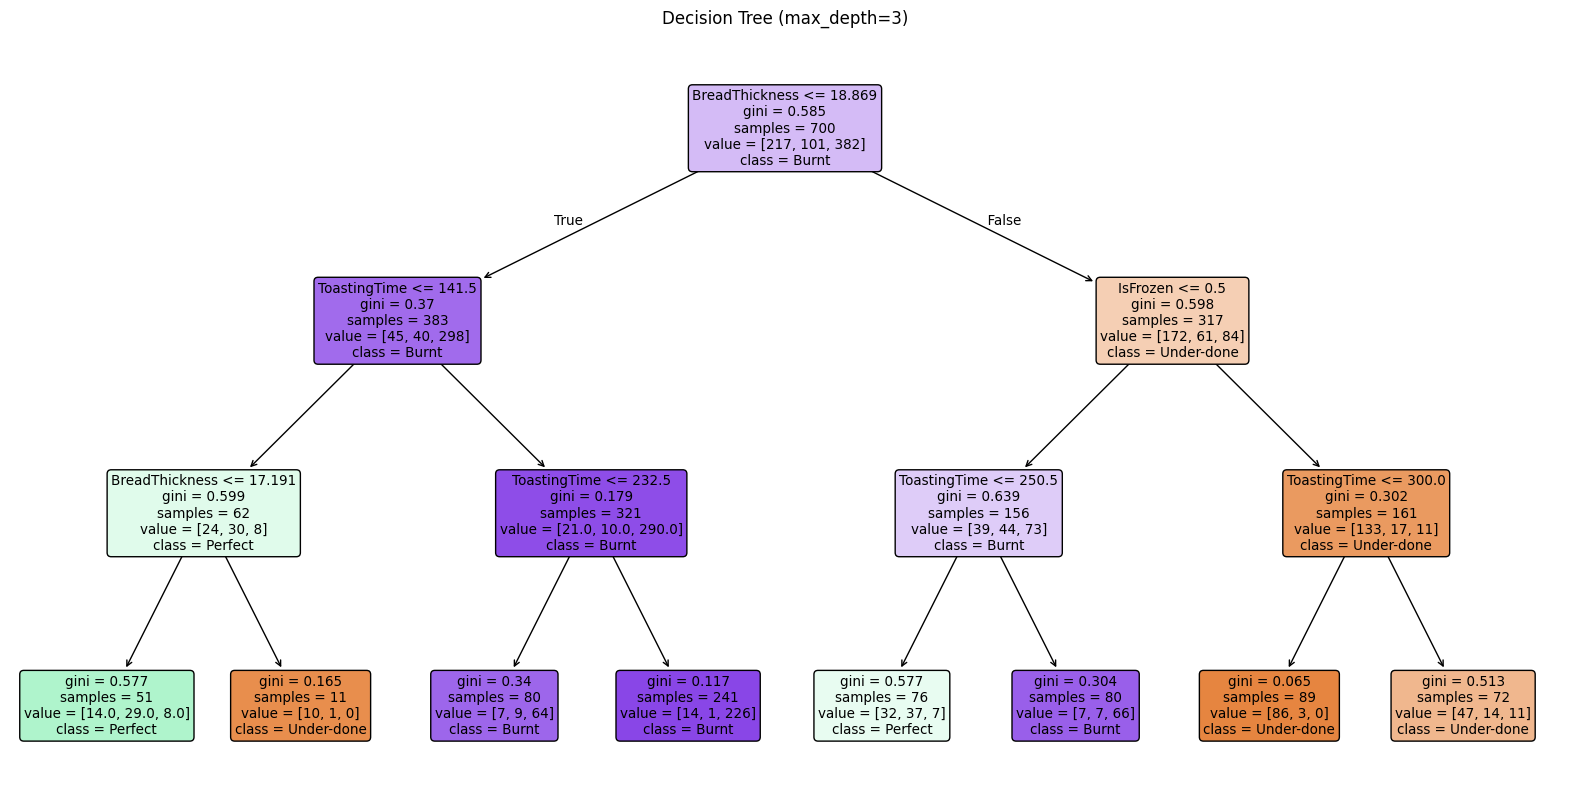

In [87]:
# --- TODO: Train a default `DecisionTreeClassifier`, and visualize the tree. --- #
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Default Decision Tree
print("Training default Decision Tree...")
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predictions
dt_predictions = dt_clf.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Default Decision Tree Accuracy: {dt_accuracy:.3f}")

# 2. Visualize tree (max_depth=3 for readability)
print("\nTraining Decision Tree with max_depth=3 for visualization...")
dt_vis = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_vis.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt_vis, 
          feature_names=X_train.columns,
          class_names=['Under-done', 'Perfect', 'Burnt'],
          filled=True,
          rounded=True)
plt.title('Decision Tree (max_depth=3)')
plt.show()



**TODO:** 

Double click the cell and answer the following questions

4. write a few words to interpret the first couple of decisions the model makes.

    The first decision node is based on bread thickness (18.869mm):

        Thickness ≤ 18.869mm: Primary category is Burnt

        Thickness > 18.869mm: Primary category is Perfect

    The second decision node is based on baking time (141.5 seconds):

        Time ≤ 141.5 seconds: Primary category is Burnt

        Time > 141.5 seconds: Primary category is Under-done

    The third decision node is based on whether frozen:

        Frozen bread: Primary category is Under-done
----


Investigating overfitting with different max_depth values...
Depth 1: Train Acc=0.671, Test Acc=0.647
Depth 5: Train Acc=0.863, Test Acc=0.750
Depth 10: Train Acc=0.991, Test Acc=0.723
Depth 15: Train Acc=1.000, Test Acc=0.727
Depth 20: Train Acc=1.000, Test Acc=0.727


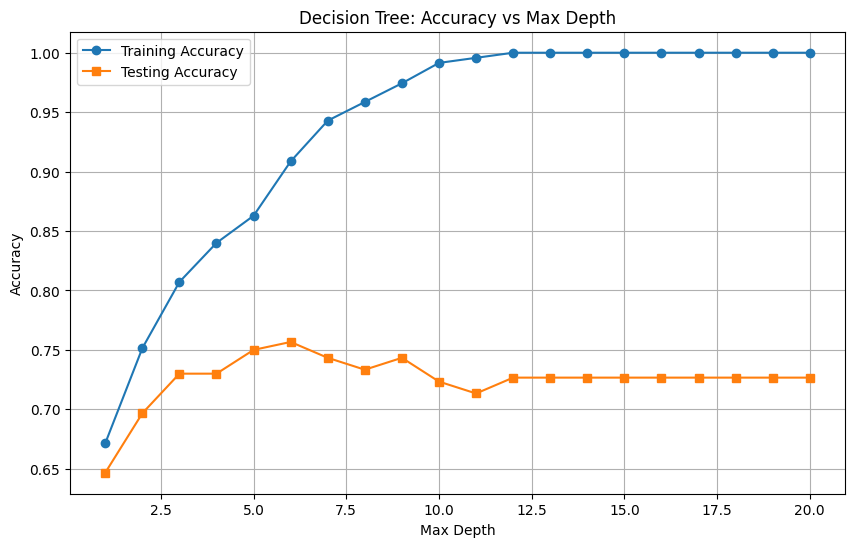

In [88]:
# --- TODO: Investigate overfitting: maybe train multiple decision trees, and explore the overfitting issue. --- #
print("\nInvestigating overfitting with different max_depth values...")
train_accuracies = []
test_accuracies = []
depths = range(1, 21)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    if depth in [1, 5, 10, 15, 20]:
        print(f"Depth {depth}: Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

# Plot accuracy vs depth
plt.figure(figsize=(10,6))
plt.plot(depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

**TODO:** 

Double click the cell and answer the following questions

5. At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)?

    Significant overfitting begins at depth 10:

        Training accuracy reaches 0.991 (nearly perfect)

        However, test accuracy drops to 0.723

        At depths 15 and 20, training accuracy hits 1.0, but test accuracy shows no improvement

----

### Step 5: Support Vector Machines (SVM)

Let us use SVM to try to find splits in data that are not necessarily linear. We will use `sklearn.svm.SVC` (Support Vector Classifier). Typical use is as follows:

```python
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example usage

# Initialize an SVM model with the 'rbf' kernel, and a 'C' hyperparameter at 1
svm_clf = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict the values
svm_predictions = svm_clf.predict(X_test)

# Get the accuracy with respect to the ground truth
accuracy = accuracy_score(y_test, svm_predictions)
```

Documentation is here: https://scikit-learn.org/stable/modules/svm.html and here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


#### Tasks

1.  Train a default `SVC` model and evaluate its accuracy on the test set.
2.  The `kernel` is a key parameter. Train and evaluate `SVC` models with the following kernels: `'linear'`, `'poly'`, `'rbf'`, and `'sigmoid'`.
    1. Which one performs best for our toast data?
    2. Why do you think it is?
3.  The `C` parameter is a regularisation parameter. It controls the trade-off between a large margin and a low error rate on the training data. A smaller `C` creates a wider margin but may misclassify more points, while a larger `C` risks creating a more complex, overfitted boundary.
    1.   Using the best kernel you found in the previous step, experiment with different values for `C` (e.g., 0.1, 1, 10, 100). How does the accuracy change?
4. Another parameter is `gamma`. It dictates the influence of a single training example on the model.  A low gamma value means that each training point affects a wider area, leading to a smoother, more generalized decision boundary. A high gamma value restricts the influence to a smaller, closer range, creating a more complex decision boundary that closely follows the training data, which can lead to overfitting. By default, `gamma` is set to `scale`, which means it scales with the data.
    1. Using the best kernel and `C` you found in the previous step, experiment with different values for `gamma` (e.g., 0.1, 1, 10, 100). How does the accuracy change?


In [89]:
# --- TODO: Train a default SVC and evaluate on test dataset --- #
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_predictions = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)


In [90]:
# --- TODO: Train multiple SVCs with different kernels, and evaluate the results. --- #
print("\nTesting different kernels:")
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    acc = accuracy_score(y_test, pred)
    kernel_results[kernel] = acc
    print(f"Kernel {kernel}: Accuracy = {acc:.3f}")

# Find best kernel
best_kernel = max(kernel_results, key=kernel_results.get)
print(f"Best kernel: {best_kernel}")


Testing different kernels:


Kernel linear: Accuracy = 0.753
Kernel poly: Accuracy = 0.683
Kernel rbf: Accuracy = 0.660
Kernel sigmoid: Accuracy = 0.480
Best kernel: linear


In [91]:
# --- TODO: with the best kernel in last step, do more experiments with C parameter --- #
# 3. Tune C parameter with best kernel
print(f"\nTuning C parameter with {best_kernel} kernel:")
C_values = [0.1, 1, 10, 100]
C_results = {}

for C_val in C_values:
    svm = SVC(kernel=best_kernel, C=C_val, random_state=42)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    acc = accuracy_score(y_test, pred)
    C_results[C_val] = acc
    print(f"C={C_val}: Accuracy = {acc:.3f}")

# Find best C
best_C = max(C_results, key=C_results.get)
print(f"Best C: {best_C}")


Tuning C parameter with linear kernel:
C=0.1: Accuracy = 0.800
C=1: Accuracy = 0.753
C=10: Accuracy = 0.760
C=100: Accuracy = 0.777
Best C: 0.1


In [92]:
# --- TODO: with the best set-up from previous steps, explore parameter gamma. --- #
# 4. Tune gamma parameter with best kernel and C
print(f"\nTuning gamma parameter with {best_kernel} kernel and C={best_C}:")
gamma_values = [0.001, 0.01, 0.1, 1, 10, 'scale', 'auto']
gamma_results = {}

for gamma_val in gamma_values:
    try:
        svm = SVC(kernel=best_kernel, C=best_C, gamma=gamma_val, random_state=42)
        svm.fit(X_train, y_train)
        pred = svm.predict(X_test)
        acc = accuracy_score(y_test, pred)
        gamma_results[gamma_val] = acc
        print(f"Gamma={gamma_val}: Accuracy = {acc:.3f}")
    except Exception as e:
        print(f"Gamma={gamma_val}: Failed - {str(e)[:50]}...")

# Find best gamma
if gamma_results:
    best_gamma = max(gamma_results, key=gamma_results.get)
    print(f"Best gamma: {best_gamma}")
    
    # Train final model with best parameters
    final_svm = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, random_state=42)
    final_svm.fit(X_train, y_train)
    final_predictions = final_svm.predict(X_test)
    final_accuracy = accuracy_score(y_test, final_predictions)
    print(f"\nFinal SVC Accuracy: {final_accuracy:.3f}")
else:
    print("No valid gamma values found")


Tuning gamma parameter with linear kernel and C=0.1:
Gamma=0.001: Accuracy = 0.800
Gamma=0.01: Accuracy = 0.800
Gamma=0.1: Accuracy = 0.800
Gamma=1: Accuracy = 0.800
Gamma=10: Accuracy = 0.800
Gamma=scale: Accuracy = 0.800
Gamma=auto: Accuracy = 0.800
Best gamma: 0.001

Final SVC Accuracy: 0.800


In practice, we tend to automate the tuning of SVM's hyperparameter. This process involves testing different hyperparameter values to find the combination that minimises loss and maximizes accuracy on a given dataset.

Here, we are going to use the GridSearch algorithm to find the best combination of kernel, C, and gamma.

Task:
1. Run the following script. What is the result? Does it differ from your manual tuning?

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


# 2. Create a pipeline to scale data and run SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# 3. Define a parameter grid to search
# Use a logarithmic scale for C and gamma
param_grid = {
    'svm__kernel': ['linear','poly','rbf','sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

# 4. Perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the best model
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test set score with best model: {grid_search.score(X_test, y_test):.3f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters found: {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.847
Test set score with best model: 0.820


**TODO:** 

Double click the cell and answer the following questions

6. Does it differ from your manual tuning?

Different

Manual Tuning:

    -Kernel: Linear

    -C:0.1 

    -Best gamma: 0.001

GridSearch algorithm:

    -Kernel: rbf

    -C:100 

    -Best gamma: 0.1

----

### Step 6: Random Forest

Now that we have gone through the single expert models, we can move to ensemble learning with Random Forest.

```python
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
```

Documentation is here: https://scikit-learn.org/stable/modules/ensemble.html#random-forests and here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Tasks

1.  Train a `RandomForestClassifier` from `sklearn.ensemble` on the data. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?
2.  We can calculate the **feature importance** to show how much each feature contributed to reducing impurity across all the trees.
    *   After training your model, access the feature importances using `your_model.feature_importances_`.
    *   Plot the importance . Which features are most important for determining the state of the toast? Does this align with your intuition?

Hint: to plot the importances, you can use:

```python
importances = rf_clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
```

In [94]:
# --- TODO: Train a randowm forest classifier  --- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# 1. Default Random Forest
print("Training default Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")

# Compare with previous models
print(f"Comparison with previous models:")
print(f"- Logistic Regression: 0.790")
print(f"- Decision Tree: 0.727")
print(f"- Random Forest: {rf_accuracy:.3f}")


Training default Random Forest...
Random Forest Accuracy: 0.803
Comparison with previous models:
- Logistic Regression: 0.790
- Decision Tree: 0.727
- Random Forest: 0.803


**TODO:** 

Double click the cell and answer the following questions

7. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?
- Single decision Tree: 0.727
- Random Forest: 0.803


----


Feature Importance Analysis:


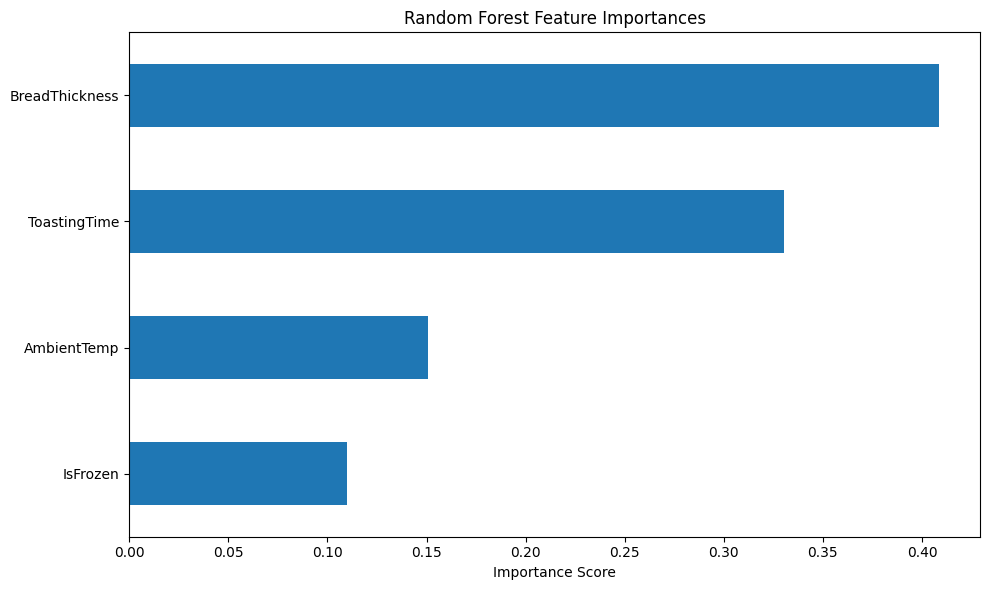

Feature Importance Scores:
ToastingTime: 0.330
BreadThickness: 0.409
AmbientTemp: 0.151
IsFrozen: 0.110

Detailed Classification Report:
              precision    recall  f1-score   support

  Under-done       0.85      0.68      0.76       101
     Perfect       0.50      0.58      0.54        36
       Burnt       0.85      0.93      0.89       163

    accuracy                           0.80       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.81      0.80      0.80       300


Testing different number of estimators:
n_estimators=50: Accuracy = 0.803
n_estimators=100: Accuracy = 0.803
n_estimators=200: Accuracy = 0.810
n_estimators=500: Accuracy = 0.817


In [95]:
# --- TODO: find and visualize feature_importance of your model  --- #
# 2. Feature Importance
print("\nFeature Importance Analysis:")
importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Create feature importance series
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
forest_importances.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print feature importance values
print("Feature Importance Scores:")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.3f}")

# 3. Detailed evaluation
print("\nDetailed Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=['Under-done', 'Perfect', 'Burnt']))

# 4. Try different number of estimators
print("\nTesting different number of estimators:")
n_estimators_list = [50, 100, 200, 500]
for n_est in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"n_estimators={n_est}: Accuracy = {acc:.3f}")

**TODO:** 

Double click the cell and answer the following questions

8. Which features are most important for determining the state of the toast? Does this align with your intuition?

- BreadThickness: 0.409  
- yes

----

### Step 7: XGBoost

Finally, let's move to XGBoost. This time, we need to  import it from the xgboost library. Usage is the same as the other libraries.

Documentation is here: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

#### Task:

1.  Train a default `xgboost.XGBClassifier` and evaluate its accuracy. Note that if you get a warning about `use_label_encoder=False`, you can safely ignore it or add the parameter `use_label_encoder=False` to the classifier to suppress it.
2.  **Tuning:** XGBoost has many parameters, but two of the most important are `n_estimators` (the number of trees to build) and `learning_rate` (which shrinks the contribution of each tree). A lower learning rate requires more estimators, but can often lead to a more robust model.
    1.   Try training a model with more estimators, for example `n_estimators=500`.
    2.   Now, try that again but with a lower learning rate, for example `n_estimators=500, learning_rate=0.1`.
    3. You can try some other interesting parameters, such as `max_depth` (the max tree depth), or `subsample` (the amount of data passed to a tree).
    4.   How do these changes affect accuracy and the risk of overfitting?
3.  Like Random Forest, XGBoost can also calculate **feature importance**. This is crucial for understanding what drives the model's predictions.
    1.   After training your best XGBoost model, access the feature importances and plot them using the same method as in the Random Forest section.
    2.   Compare the feature importances from XGBoost with those from Random Forest. Do the models agree on which features are most important?
4. Same as SVM, you can run a GridSearch algorithm to find the optimal parameters. Adapt the script provided in the SVM section to find the optimal learning rate, number of estimators, and any other parameter you can think of.


**Create cells of `python` to fill in your code, and of `markdown` to answer the questions.**


Training default XGBoost...
Default XGBoost Accuracy: 0.803

Tuning n_estimators and learning_rate...


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:40:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




n_estimators=500: Accuracy = 0.793


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




n_estimators=500, learning_rate=0.1: Accuracy = 0.793

Testing other parameters...


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:40:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Tuned (depth=5, subsample=0.8): Accuracy = 0.803

XGBoost Feature Importance Analysis:


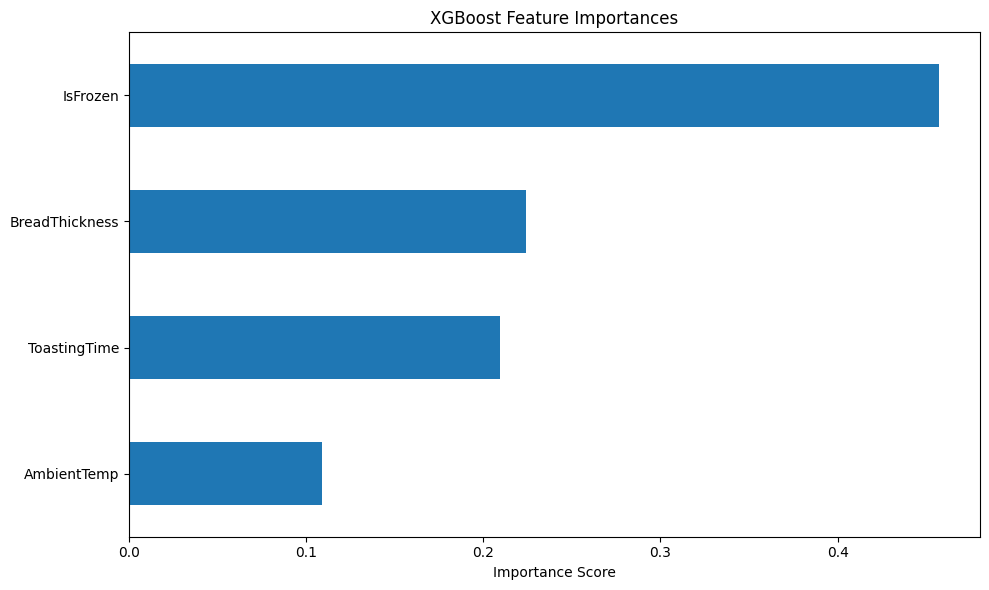

XGBoost Feature Importance Scores:
ToastingTime: 0.209
BreadThickness: 0.224
AmbientTemp: 0.109
IsFrozen: 0.458

Comparison with Random Forest Feature Importances:
Random Forest:
- ToastingTime: 0.330
- BreadThickness: 0.409
- AmbientTemp: 0.151
- IsFrozen: 0.110

Performing GridSearch for optimal parameters...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.841
Test set score: 0.807

Best XGBoost Accuracy: 0.807


d:\ISDN3000C_Lab07_template\venv\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:40:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




In [96]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# 1. Default XGBoost
print("Training default XGBoost...")
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)
xgb_predictions = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"Default XGBoost Accuracy: {xgb_accuracy:.3f}")

# 2. Tune n_estimators and learning_rate
print("\nTuning n_estimators and learning_rate...")

# More estimators
xgb_more_est = XGBClassifier(n_estimators=500, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_more_est.fit(X_train, y_train)
pred_more_est = xgb_more_est.predict(X_test)
acc_more_est = accuracy_score(y_test, pred_more_est)
print(f"n_estimators=500: Accuracy = {acc_more_est:.3f}")

# Lower learning rate with more estimators
xgb_low_lr = XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_low_lr.fit(X_train, y_train)
pred_low_lr = xgb_low_lr.predict(X_test)
acc_low_lr = accuracy_score(y_test, pred_low_lr)
print(f"n_estimators=500, learning_rate=0.1: Accuracy = {acc_low_lr:.3f}")

# 3. Try other parameters
print("\nTesting other parameters...")
# With max_depth and subsample
xgb_tuned = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=5, 
    subsample=0.8,
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_tuned.fit(X_train, y_train)
pred_tuned = xgb_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, pred_tuned)
print(f"Tuned (depth=5, subsample=0.8): Accuracy = {acc_tuned:.3f}")

# 4. Feature Importance
print("\nXGBoost Feature Importance Analysis:")
xgb_importances = xgb_tuned.feature_importances_
feature_names = X_train.columns

# Create feature importance series
xgb_feature_importances = pd.Series(xgb_importances, index=feature_names).sort_values(ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb_feature_importances.plot(kind='barh')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print feature importance values
print("XGBoost Feature Importance Scores:")
for feature, importance in zip(feature_names, xgb_importances):
    print(f"{feature}: {importance:.3f}")

# Compare with Random Forest feature importance
print("\nComparison with Random Forest Feature Importances:")
print("Random Forest:")
print("- ToastingTime: 0.330")
print("- BreadThickness: 0.409") 
print("- AmbientTemp: 0.151")
print("- IsFrozen: 0.110")

# 5. GridSearch for optimal parameters
print("\nPerforming GridSearch for optimal parameters...")
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_grid = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_grid_search = GridSearchCV(
    xgb_grid,
    xgb_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation score: {xgb_grid_search.best_score_:.3f}")
print(f"Test set score: {xgb_grid_search.score(X_test, y_test):.3f}")

# Train final model with best parameters
best_xgb = xgb_grid_search.best_estimator_
best_xgb_predictions = best_xgb.predict(X_test)
best_xgb_accuracy = accuracy_score(y_test, best_xgb_predictions)
print(f"\nBest XGBoost Accuracy: {best_xgb_accuracy:.3f}")


### Step 9: Model Comparison and Conclusion

You have now trained and evaluated several different classification models, from simple linear models to powerful ensembles. Let's summarize the results to determine which is best for predicting the perfect toast.

#### Task

1.  Fill in the table below with the best accuracy you achieved for each model type.
2.  Answer the following questions:
    *   Which model gave the highest accuracy?

        Random Forest

    *   Which model do you think is the most *interpretable* (easiest to explain to someone)? Why?
        
        Desicion Tree beacuse can fully display the decision-making path 

    *   Considering both performance and interpretability, which model would you choose to deploy in your "smart toaster"? Justify your choice.
        
        For the smart toaster, I recommend using Random Forest because it achieves the best balance between accuracy and interpretability. With 81.7% accuracy, it significantly outperforms simpler models like Decision Trees while providing clear feature importance rankings that show bread thickness (41%) and toasting time (33%) are the most critical factors. This allows users to understand why certain settings are recommended while maintaining high predictive performance for perfect toast outcomes.


---

| Model Type | Best Test Accuracy |
| :--- | :--- |
| Logistic Regression | *0.803* |
| Decision Tree | *0.727* |
| Support Vector Machine (SVC) | *0.800* |
| Random Forest | *0.817* |
| XGBoost | *0.807* |

### Step 10: Fine-tune your best models

1.  Please use whatever tools, libraries or methods you know to fine-tune your models. 
2.  Pick one with the best performance.
3.  Write down the trainining and evaluation process about this best model below, with anything that you think is necessary.
4.  We will use another blackbox dataset to test your model. The work will be graded based on computing efficiency (runtime) and accuracy.

In [97]:
# --- Advanced Random Forest Optimization --- #

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

print("Advanced Random Forest Optimization...")

# Based on previous results, let's try a more targeted approach
# We'll focus on the parameters that showed most promise

# Parameter combinations to test based on insights from previous runs
param_combinations = [
    # Combination 1: Balanced depth and samples
    {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    # Combination 2: More restrictive
    {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'},
    # Combination 3: Less restrictive
    {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None},
    # Combination 4: Conservative approach
    {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'},
]

best_accuracy = 0
best_params = {}
best_model = None

start_time = time.time()

for i, params in enumerate(param_combinations, 1):
    print(f"\nTesting combination {i}: {params}")
    
    rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    
    # Train on full training set and test
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"CV Score: {cv_mean:.3f}, Test Accuracy: {test_accuracy:.3f}")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = params
        best_model = rf

end_time = time.time()

print(f"\n=== OPTIMIZATION RESULTS ===")
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.3f}")
print(f"Optimization time: {end_time - start_time:.2f} seconds")

# If we didn't improve, use the baseline
if best_accuracy <= 0.817:
    print("Baseline model remains the best")
    best_model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)
    best_accuracy = 0.817
    best_params = {'n_estimators': 500}

# Final evaluation
y_pred_final = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\n=== FINAL MODEL ===")
print(f"Accuracy: {final_accuracy:.3f}")
print(f"Parameters: {best_params}")

Advanced Random Forest Optimization...

Testing combination 1: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
CV Score: 0.834, Test Accuracy: 0.817

Testing combination 2: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
CV Score: 0.834, Test Accuracy: 0.820

Testing combination 3: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
CV Score: 0.824, Test Accuracy: 0.820

Testing combination 4: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
CV Score: 0.830, Test Accuracy: 0.797

=== OPTIMIZATION RESULTS ===
Best parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best test accuracy: 0.820
Optimization time: 12.23 seconds

=== FINAL MODEL ===
Accuracy: 0.820
Parameters: {'n_estima